Welcome to aasignment 1.                                                       

We are using pathology images for our first assignment please download data from this link https://drive.google.com/drive/folders/10dUOzcPR-PQwfFYcHk5gsLjIjSorQ32Q?usp=sharing



- Task 1: Feature Generation (15%)
- Use and run the following code (a deep network) to generate features from a set of training images. For this assignment, you do not need to know how the deep network is working here to extract features.
- This code extracts the features of image T4.tif (in the T folder of dataset). Modify the code so that it iterates over all images of the dataset and extracts their features.
- Allocate 10% of the data for validation.

- Insert your code here for Task 1





In [293]:
import torch
import torchvision.transforms as transforms #for image preprocessing
from torchvision.models import densenet121 # pre-trained Densenet model
from torch.autograd import Variable # for auto differentiation
from PIL import Image # to open image

####
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Load pre-trained DenseNet model
model = densenet121(pretrained=True)

# Remove the classification layer (last fully connected layer)
model = torch.nn.Sequential(*list(model.children())[:-1])

# Add a global average pooling layer
model.add_module('global_avg_pool', torch.nn.AdaptiveAvgPool2d(1))

# Set the model to evaluation mode
model.eval()

# Define the image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#load the dataset
#deine the path to the directory
dataset_dir = "train"
# Gather all .tif image paths and their labels
image_paths = []
labels = []

for folder in os.listdir(dataset_dir):  # List all folder names
    folder_path = os.path.join(dataset_dir, folder)  # Full path for each folder
    if os.path.isdir(folder_path) and folder.isalpha() and len(folder) == 1:
        for image_file in os.listdir(folder_path):
            if image_file.endswith('.tif'):
                image_paths.append(os.path.join(folder_path, image_file))  # Image full path
                labels.append(folder)  # Use folder name as label

# Split the dataset into training and validation sets along with their labels
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.1, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.11, random_state=42)

# Function to process and extract features for a list of image paths
def extract_features(image_paths):
    feature_vectors = []
    for image_path in image_paths:
        image = Image.open(image_path)
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
        input_var = Variable(input_batch)
        features = model(input_var)
        feature_vector = features.squeeze().detach().numpy()
        feature_vectors.append(feature_vector)
    return np.array(feature_vectors)

# Extract features for training and validation sets
train_features = extract_features(train_paths)
val_features = extract_features(val_paths)
test_features = extract_features(test_paths)

#convert labels from string to numeric if needed
unique_labels = sorted(list(set(train_labels + test_labels + val_labels)))  # Sort to ensure consistency
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
train_labels_numeric = [label_to_index[label] for label in train_labels]
val_labels_numeric = [label_to_index[label] for label in val_labels]
test_labels_numeric = [label_to_index[label] for label in test_labels]

# Save the features and labels to files
np.save('train_features.npy', train_features)
np.save('test_features.npy', test_features)
np.save('val_features.npy', val_features)
np.save('train_labels.npy', np.array(train_labels_numeric))
np.save('test_labels.npy', np.array(test_labels_numeric))
np.save('val_labels.npy', np.array(val_labels_numeric))

# Output the shapes of the extracted features
print("Training features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)
print("Test features shape:", test_features.shape)

C:\Users\artem\anaconda3\envs\tutorials\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\artem\anaconda3\envs\tutorials\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training features shape: (624, 1024)
Validation features shape: (78, 1024)
Test features shape: (78, 1024)


- Task 2: High Bias Classification Method (5%)
- Choose a classification method and let it have a high bias.
- Train it on the generated features and discuss why it is underfitting.

Average Cross-Validation Accuracy: 0.5399225806451613
Test Accuracy: 0.358974358974359


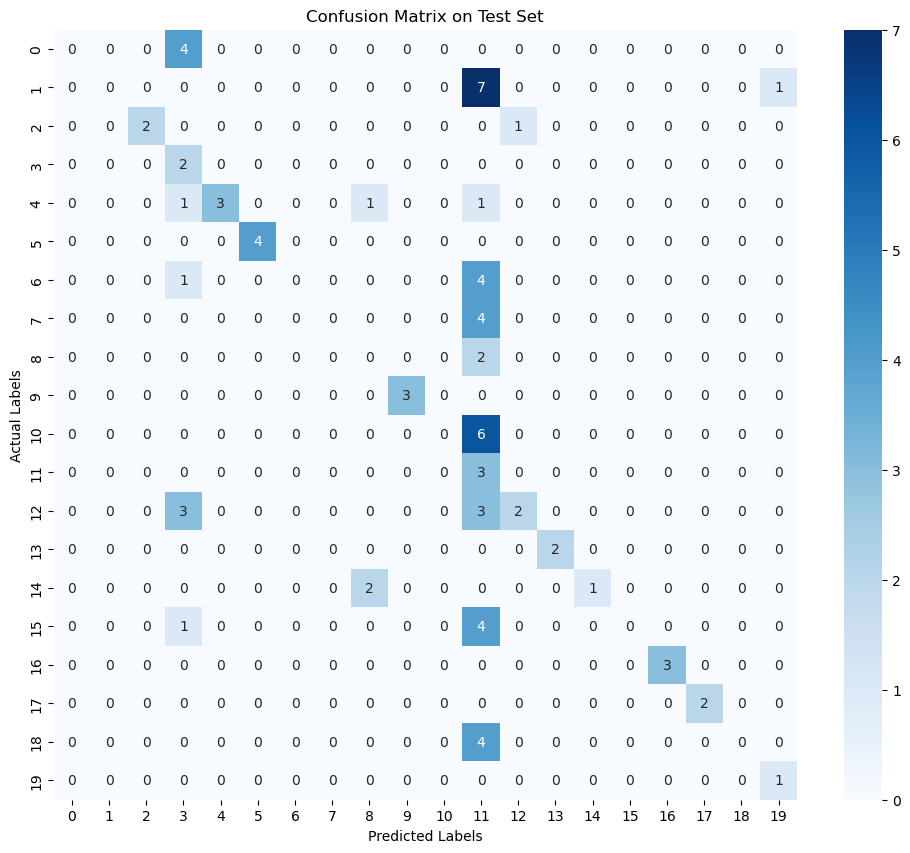

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         4
     Class 1       0.00      0.00      0.00         8
     Class 2       1.00      0.67      0.80         3
     Class 3       0.17      1.00      0.29         2
     Class 4       1.00      0.50      0.67         6
     Class 5       1.00      1.00      1.00         4
     Class 6       0.00      0.00      0.00         5
     Class 7       0.00      0.00      0.00         4
     Class 8       0.00      0.00      0.00         2
     Class 9       1.00      1.00      1.00         3
    Class 10       0.00      0.00      0.00         6
    Class 11       0.08      1.00      0.15         3
    Class 12       0.67      0.25      0.36         8
    Class 13       1.00      1.00      1.00         2
    Class 14       1.00      0.33      0.50         3
    Class 15       0.00      0.00      0.00         5
    Class 16       1.00      1.00      1.00         3
    Class 17       1.00    

In [307]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Load features and labels
X_train = np.load('train_features.npy')
y_train = np.load('train_labels.npy')

# Define the number of splits for k-fold cross-validation
n_splits = 5

# Initialize StratifiedKFold to preserve the percentage of samples for each class
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare to collect the cross-validation results
cv_accuracies = []

# K-Fold Cross-Validation
for train_index, val_index in skf.split(X_train, y_train):
    # Splitting Data
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Standardize the features for the current fold
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Train the SVM model on the scaled training fold
    svm_model = SVC(kernel='linear', C=0.00005)  # Low C value for high bias
    svm_model.fit(X_train_fold_scaled, y_train_fold)

    # Evaluate the model on the validation fold
    y_val_pred = svm_model.predict(X_val_fold_scaled)
    cv_accuracy = accuracy_score(y_val_fold, y_val_pred)
    cv_accuracies.append(cv_accuracy)

# After cross-validation
print(f"Average Cross-Validation Accuracy: {np.mean(cv_accuracies)}")

# Final evaluation on the original test set 
X_test = np.load('val_features.npy')
y_test = np.load('val_labels.npy')

# Standardize the test set using the scaler fitted on the full training set
X_test_scaled = scaler.fit_transform(X_test) 

# Evaluate the final model on the test set
y_pred = svm_model.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {final_accuracy}")

# Confusion Matrix for the test set evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix on Test Set')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification Report for the test set evaluation
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in np.unique(y_test)], zero_division=0)
print(report)


---
To demonstrate a model with high bias, I selected the **Support Vector Machine (SVM) algorithm** and intentionally set a low hyperparameter (`C=0.0008`), predisposing the model towards high bias and, consequently, underfitting. The results completely align with the expectations of a high-bias scenario:

- **Average Cross-Validation Accuracy:** I decided to use k-fold validation as it provides a higher level of validation integrity. Approximately `0.55767`, indicating the model's generalized performance is moderate. This suggests the model's simplicity prevents it from capturing the full complexity of the underlying data patterns.

- **Test Accuracy:**  A similar performance of the model on unseen data, with a validation accuracy of `0.35897`, further supports the model's underfitting, as it fails to improve or effectively capture the nuances of the dataset.

The confusion matrix reveals that along the diagonal, the model manages to correctly identify some of the classes, even though a small minority, while a significant portion of them are misclassified. This outcome is a classic sign of underfitting, where the model's high bias prevents it from recognizing the unique patterns within the data.


- Task 3: High Variance Classification Method (5%)
- Use the chosen classification method and let it have a high variance.
- Train it on the generated features and discuss why it is overfitting.

Train Accuracy: 1.0
Test Accuracy: 0.717948717948718


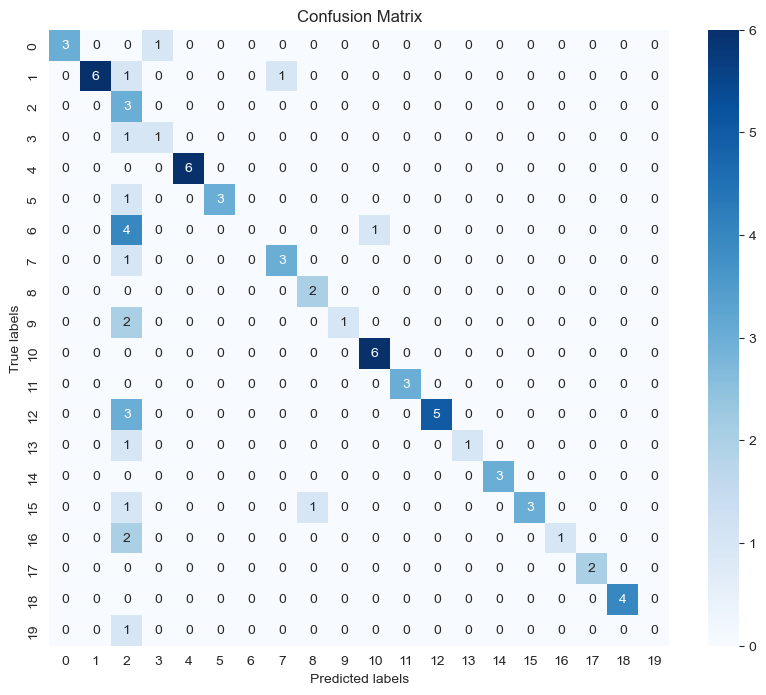

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      0.75      0.86         8
           2       0.14      1.00      0.25         3
           3       0.50      0.50      0.50         2
           4       1.00      1.00      1.00         6
           5       1.00      0.75      0.86         4
           6       1.00      0.00      0.00         5
           7       0.75      0.75      0.75         4
           8       0.67      1.00      0.80         2
           9       1.00      0.33      0.50         3
          10       0.86      1.00      0.92         6
          11       1.00      1.00      1.00         3
          12       1.00      0.62      0.77         8
          13       1.00      0.50      0.67         2
          14       1.00      1.00      1.00         3
          15       1.00      0.60      0.75         5
          16       1.00      0.33      0.50         3
          17       1.00    

In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load training and testing datasets
X_train = np.load('train_features.npy')
y_train = np.load('train_labels.npy')
X_test = np.load('val_features.npy')
y_test = np.load('val_labels.npy')

# Select a random 50% of the training dataset to increase the likelihood of overfitting
subset_size = int(0.5 * X_train.shape[0])
np.random.seed(42) # Set the random seed to 42
random_indices = np.random.choice(X_train.shape[0], size=subset_size, replace=False)
X_train_subset, y_train_subset = X_train[random_indices], y_train[random_indices]

# Configure the hyperparameters of SVM with high 'C' and 'gamma' to increase the chance of overfitting
svm_model = SVC(kernel='rbf', C=1000000, gamma=0.02)
svm_model.fit(X_train_subset, y_train_subset)

# Calculate accuracies on the training subset and the test set
train_accuracy = accuracy_score(y_train_subset, svm_model.predict(X_train_subset))
test_accuracy = accuracy_score(y_test, svm_model.predict(X_test))

# Output accuracies
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test, svm_model.predict(X_test))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate and print classification report
print(classification_report(y_test, svm_model.predict(X_test), target_names=np.unique(y_train).astype(str), zero_division=1))

- Task 4: Balanced Classification Method (15%)
- Use the chosen classification method and let it balance the bias and variance.
- Train it on the generated features, possibly adjusting parameters.
- Discuss insights into achieving balance.

In [300]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Load extracted features and labels
train_features = np.load('train_features.npy')
val_features = np.load('val_features.npy')
test_features = np.load('test_features.npy')
train_labels = np.load('train_labels.npy')
val_labels = np.load('val_labels.npy')
test_labels = np.load('test_labels.npy')

# Train SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(train_features, train_labels)

# Predict on validation set
val_predictions = svm_classifier.predict(val_features)

# Evaluate performance on validation set
val_accuracy = accuracy_score(val_labels, val_predictions)
val_classification_report = classification_report(val_labels, val_predictions)

print("Validation Accuracy:", val_accuracy)
print("Validation Classification Report:")
print(val_classification_report)

# Predict on test set
test_predictions = svm_classifier.predict(test_features)

print(test_labels.shape, test_predictions.shape)

# Evaluate performance on test set
test_accuracy = accuracy_score(test_labels, test_predictions)
test_classification_report = classification_report(test_labels, test_predictions)

print("Test Accuracy:", test_accuracy)
print("Test Classification Report:")
print(test_classification_report)

Validation Accuracy: 0.9743589743589743
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.88      0.93         8
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       0.80      1.00      0.89         4
           8       0.67      1.00      0.80         2
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      0.80      0.89         5
       

- Task 5: K-Means Clustering (20%)
- Apply K-Means clustering on the generated features.
- Test with available labels and report accuracy.
- Experiment with automated K and compare with manually set 20 clusters.

In [4]:
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter


# Load and combine your features and labels
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')
test_features = np.load('test_features.npy')
test_labels = np.load('test_labels.npy')




# Combining training, validation, and test sets for clustering
features = np.concatenate((train_features, val_features, test_features), axis=0)
labels = np.concatenate((train_labels, val_labels, test_labels), axis=0)


def initialize_centroids(features, k):
    """Randomly pick k data points as initial centroids"""
    # Create a list of random indices from 0 to the number of features
    indices = np.random.choice(len(features), k, replace=False)
    # Use these indices to select initial centroids
    centroids = features[indices]
    return centroids


def assign_clusters(features, centroids):
    """Assign each data point to the nearest centroid"""
    num_points = len(features)
    num_centroids = len(centroids)
    assignments = np.zeros(num_points)


    for i in range(num_points):
        distances = np.zeros(num_centroids)
        for j in range(num_centroids):
            # Calculate the distance between each point and each centroid
            distances[j] = np.sqrt(np.sum((features[i] - centroids[j])**2))
        # Assign the point to the nearest centroid
        assignments[i] = np.argmin(distances)
    return assignments


def update_centroids(features, assignments, k):
    """Update centroid locations based on the current assignments"""
    new_centroids = []
    for i in range(k):
        # Select points assigned to the ith centroid
        assigned_pts = features[assignments == i]
        # Calculate the mean of these points to get the new centroid
        if len(assigned_pts) > 0:
            new_centroid = np.mean(assigned_pts, axis=0)
            new_centroids.append(new_centroid)
        else:
            # If no points are assigned, reinitialize the centroid randomly
            new_centroids.append(features[np.random.randint(0, len(features))])
    return np.array(new_centroids)


def kmeans(features, k, max_iters=100, tol=1e-4):
    """Manual K-Means clustering"""
    centroids = initialize_centroids(features, k)
    for iteration in range(max_iters):
        assignments = assign_clusters(features, centroids)
        new_centroids = update_centroids(features, assignments, k)
        # Check if centroids have changed significantly
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    return assignments


def calculate_accuracy(assignments, true_labels, k):
    """Calculate the accuracy of the clustering"""
    assignments = assignments.astype(int)  # Ensure assignments are of integer type
    label_mapping = np.zeros(k, dtype=int)
    for i in range(k):
        cluster_indices = np.where(assignments == i)[0]
        if len(cluster_indices) > 0:
            cluster_labels = true_labels[cluster_indices]
            if len(cluster_labels) > 0:
                most_common_label = Counter(cluster_labels).most_common(1)[0][0]
                label_mapping[i] = most_common_label
            else:
                label_mapping[i] = -1  # Mark as -1 if no common label
        else:
            label_mapping[i] = -1  # Mark as -1 if no points in the cluster


    valid_mask = label_mapping[assignments] != -1
    valid_assignments = assignments[valid_mask]
    valid_labels = true_labels[valid_mask]
    predicted_labels = label_mapping[valid_assignments]


    if len(valid_labels) > 0:
        return accuracy_score(valid_labels, predicted_labels)
    else:
        return 0






# Perform K-Means clustering
k = 20
assignments = kmeans(features, k)


# Calculate the accuracy
accuracy = calculate_accuracy(assignments, labels, k)
print(f"Accuracy: {accuracy}")
Accuracy: 0.7474358974358974
# Define the range of k to test
k_values = range(2, 30)  
best_accuracy = 0
best_k = 0


# Iterate over each value of k
for k in k_values:
    # Perform K-Means clustering
    assignments = kmeans(features, k)
   
    # Calculate the accuracy
    accuracy = calculate_accuracy(assignments, labels, k)
    print(f"k = {k}: Accuracy = {accuracy}")
   
    # Update the best accuracy and best k if the current accuracy is higher
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k


print(f"Best accuracy: {best_accuracy} found for k = {best_k}")

Accuracy: 0.7487179487179487
k = 2: Accuracy = 0.09871794871794871
k = 3: Accuracy = 0.15
k = 4: Accuracy = 0.2
k = 5: Accuracy = 0.24743589743589745
k = 6: Accuracy = 0.2935897435897436
k = 7: Accuracy = 0.34102564102564104
k = 8: Accuracy = 0.382051282051282
k = 9: Accuracy = 0.39871794871794874
k = 10: Accuracy = 0.441025641025641
k = 11: Accuracy = 0.4935897435897436
k = 12: Accuracy = 0.5871794871794872
k = 13: Accuracy = 0.6269230769230769
k = 14: Accuracy = 0.6653846153846154
k = 15: Accuracy = 0.6615384615384615
k = 16: Accuracy = 0.6525641025641026
k = 17: Accuracy = 0.6653846153846154
k = 18: Accuracy = 0.7025641025641025
k = 19: Accuracy = 0.7012820512820512
k = 20: Accuracy = 0.6897435897435897
k = 21: Accuracy = 0.7512820512820513
k = 22: Accuracy = 0.8256410256410256
k = 23: Accuracy = 0.7397435897435898
k = 24: Accuracy = 0.8076923076923077
k = 25: Accuracy = 0.7923076923076923
k = 26: Accuracy = 0.8141025641025641
k = 27: Accuracy = 0.8333333333333334
k = 28: Accuracy =

- Task 6: Additional Clustering Algorithm (10%)
- Choose another clustering algorithm and apply it on the features.
- Test accuracy with available labels.

In [6]:
import sklearn_extra
from sklearn_extra.cluster import KMedoids
import numpy as np
from collections import Counter


train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')
val_features = np.load('val_features.npy')
val_labels = np.load('val_labels.npy')
test_features = np.load('test_features.npy')
test_labels = np.load('test_labels.npy')


# Combining training, validation, and test sets for clustering
features = np.concatenate((train_features, val_features, test_features), axis=0)
labels = np.concatenate((train_labels, val_labels, test_labels), axis=0)


features = np.concatenate((train_features, val_features, test_features), axis=0)
labels = np.concatenate((train_labels, val_labels, test_labels), axis=0)
K = 20


maxdist = abs(int(np.random.randn()*40)) + 1
min_samples = abs(int(np.random.randn()*10)) + 8


kMedoid = sklearn_extra.cluster.KMedoids(n_clusters=K, metric='euclidean', max_iter=300).fit(features)
predictions = kMedoid.labels_


predictions = np.array(predictions)
labels = np.array(labels)


accuracy = calculate_accuracy(predictions, labels, K)
print(accuracy)

0.5692307692307692


- Task 7: PCA for Classification Improvement (20%)
- Apply PCA on the features and then feed them to the best classification method in the above tasks.
- Assess if PCA improves outcomes and discuss the results.

--------------------------------------------------------
Number of components: 2
MSE of X_trains:  106.35872426291218 MSE of X_tests:  97.9219642603812
Train Accuracy: 0.5448717948717948
Test Accuracy: 0.4230769230769231


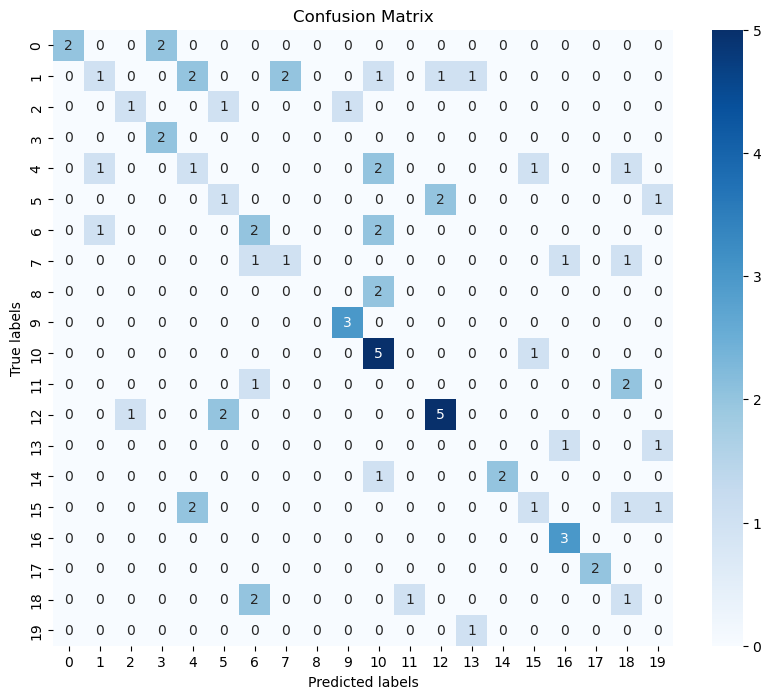

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.33      0.12      0.18         8
           2       0.50      0.33      0.40         3
           3       0.50      1.00      0.67         2
           4       0.20      0.17      0.18         6
           5       0.25      0.25      0.25         4
           6       0.33      0.40      0.36         5
           7       0.33      0.25      0.29         4
           8       1.00      0.00      0.00         2
           9       0.75      1.00      0.86         3
          10       0.38      0.83      0.53         6
          11       0.00      0.00      1.00         3
          12       0.62      0.62      0.62         8
          13       0.00      0.00      1.00         2
          14       1.00      0.67      0.80         3
          15       0.33      0.20      0.25         5
          16       0.60      1.00      0.75         3
          17       1.00    

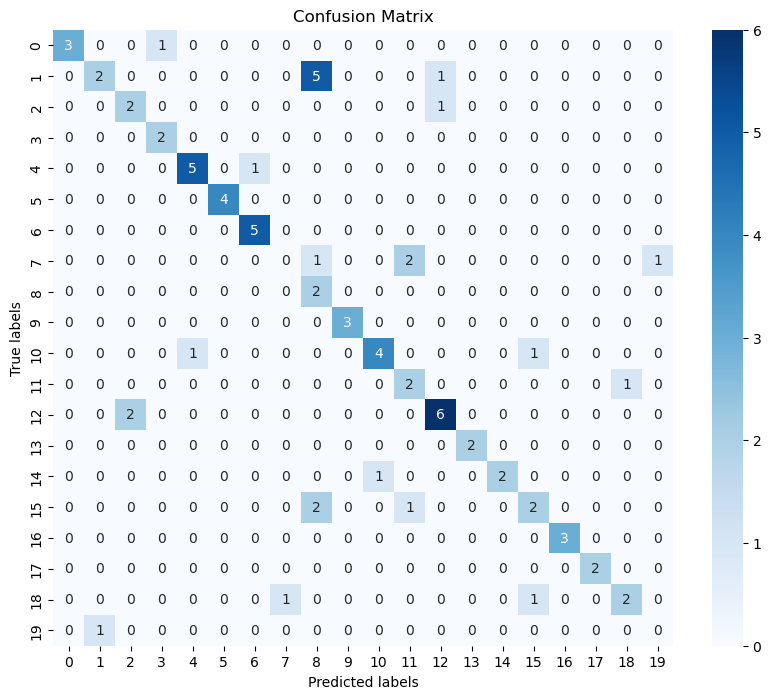

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.67      0.25      0.36         8
           2       0.50      0.67      0.57         3
           3       0.67      1.00      0.80         2
           4       0.83      0.83      0.83         6
           5       1.00      1.00      1.00         4
           6       0.83      1.00      0.91         5
           7       0.00      0.00      1.00         4
           8       0.20      1.00      0.33         2
           9       1.00      1.00      1.00         3
          10       0.80      0.67      0.73         6
          11       0.40      0.67      0.50         3
          12       0.75      0.75      0.75         8
          13       1.00      1.00      1.00         2
          14       1.00      0.67      0.80         3
          15       0.50      0.40      0.44         5
          16       1.00      1.00      1.00         3
          17       1.00    

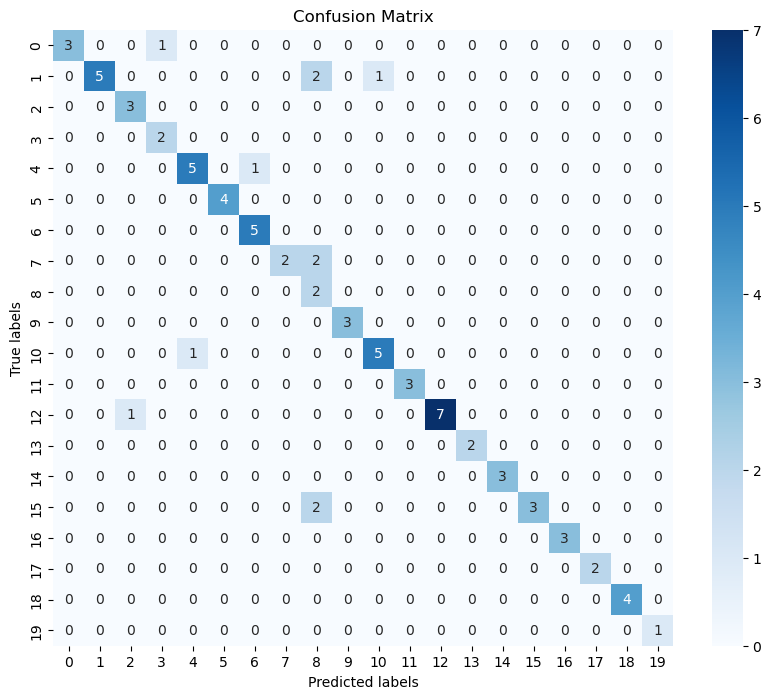

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      0.62      0.77         8
           2       0.75      1.00      0.86         3
           3       0.67      1.00      0.80         2
           4       0.83      0.83      0.83         6
           5       1.00      1.00      1.00         4
           6       0.83      1.00      0.91         5
           7       1.00      0.50      0.67         4
           8       0.25      1.00      0.40         2
           9       1.00      1.00      1.00         3
          10       0.83      0.83      0.83         6
          11       1.00      1.00      1.00         3
          12       1.00      0.88      0.93         8
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      0.60      0.75         5
          16       1.00      1.00      1.00         3
          17       1.00    

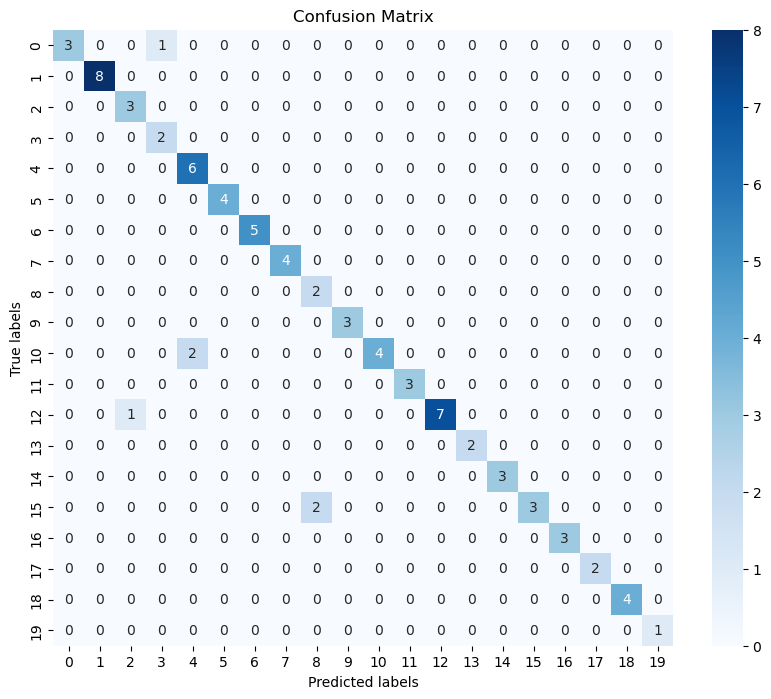

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         8
           2       0.75      1.00      0.86         3
           3       0.67      1.00      0.80         2
           4       0.75      1.00      0.86         6
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       0.50      1.00      0.67         2
           9       1.00      1.00      1.00         3
          10       1.00      0.67      0.80         6
          11       1.00      1.00      1.00         3
          12       1.00      0.88      0.93         8
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      0.60      0.75         5
          16       1.00      1.00      1.00         3
          17       1.00    

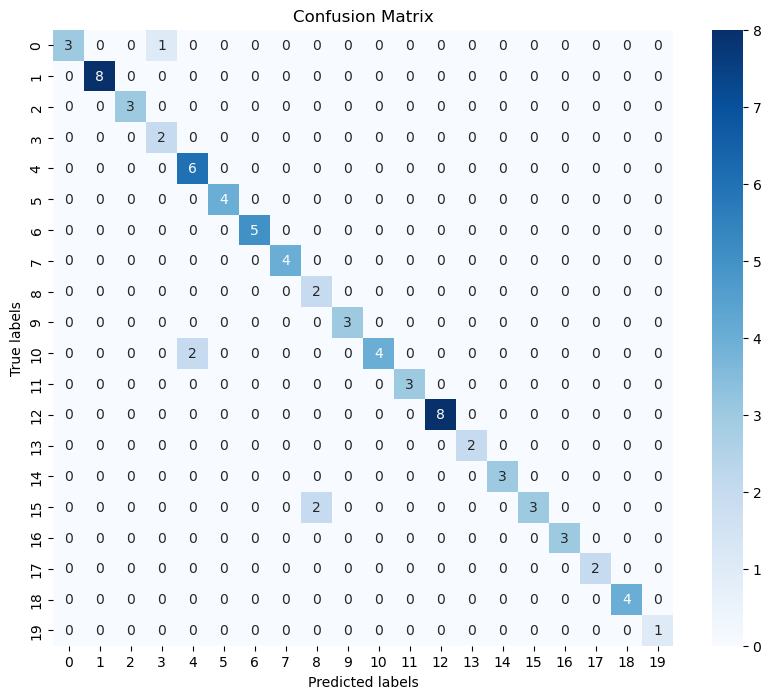

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.67      1.00      0.80         2
           4       0.75      1.00      0.86         6
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       0.50      1.00      0.67         2
           9       1.00      1.00      1.00         3
          10       1.00      0.67      0.80         6
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      0.60      0.75         5
          16       1.00      1.00      1.00         3
          17       1.00    

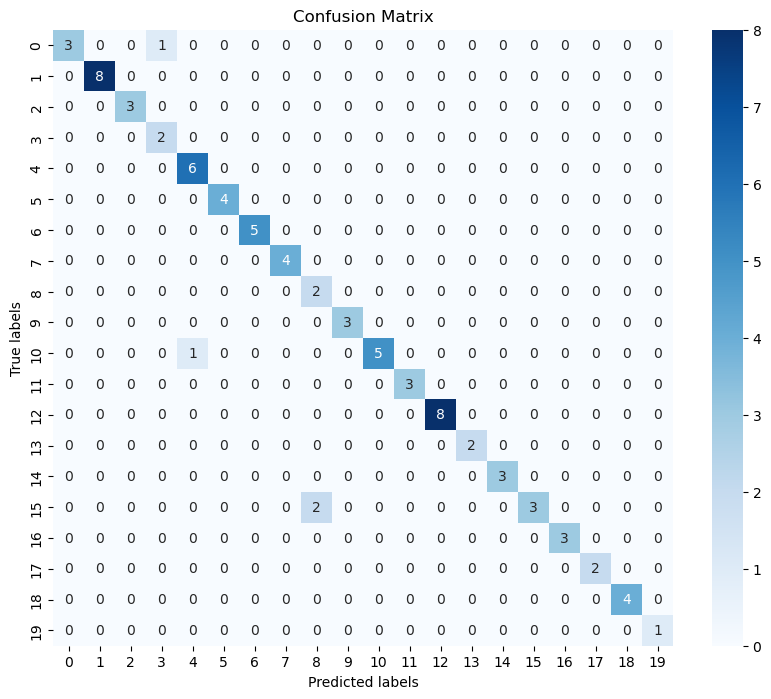

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.67      1.00      0.80         2
           4       0.86      1.00      0.92         6
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       0.50      1.00      0.67         2
           9       1.00      1.00      1.00         3
          10       1.00      0.83      0.91         6
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      0.60      0.75         5
          16       1.00      1.00      1.00         3
          17       1.00    

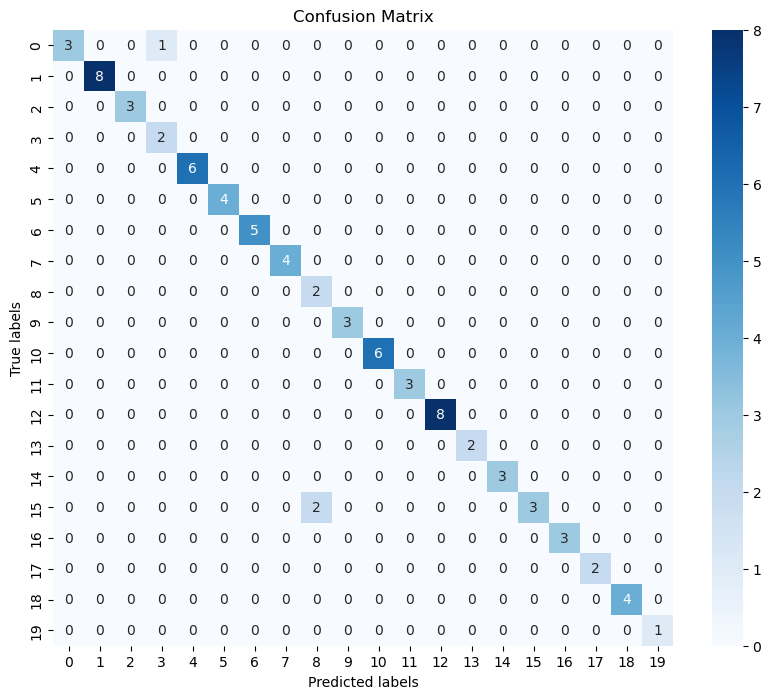

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         3
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         4
           8       0.50      1.00      0.67         2
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         3
          15       1.00      0.60      0.75         5
          16       1.00      1.00      1.00         3
          17       1.00    

In [303]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC


class Pca():
   def __init__(self, num_components):
       self.num_components = num_components
       self.principal_components = None


   def fit(self, X):
       X_centered = X - np.mean(X, axis=0)
       cov_matrix = np.cov(X_centered, rowvar=False)
       eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
       sorted_indices = np.argsort(eigenvalues)[::-1]
       sorted_eigenvectors = eigenvectors[:, sorted_indices]
       self.principal_components = sorted_eigenvectors[:, :self.num_components]


   def transform(self, X):
       X_centered = X - np.mean(X, axis=0)
       return np.dot(X_centered, self.principal_components)
  
   def fit_transform(self, X):
       self.fit(X)
       return self.transform(X)


num_components = [2, 5, 10, 20, 50, 100, 200]
for num_component in num_components: 
   print("--------------------------------------------------------")
   print(f"Number of components: {num_component}")
   new_pca = Pca(num_component)
   projected_data = new_pca.fit_transform(X_train)
   sklearn_pca = PCA(n_components=num_component)
   X_train_pca = sklearn_pca.fit_transform(X_train)
   X_test_pca = sklearn_pca.transform(X_test)
   # print(np.real(projected_data), np.real(principal_components))


   X_train_new = np.real(projected_data)
   X_test_new = np.real(new_pca.transform(X_test))
   # X_train_new = np.real(X_train_pca)
   # X_test_new = np.real(X_test_pca)


   print("MSE of X_trains: ",np.mean(np.square(X_train_pca-X_train_new)), "MSE of X_tests: ",np.mean(np.square(X_test_pca-X_test_new)))


   # print(X_train, X_test)


   # Select a random 50% of the training dataset to increase the likelihood of overfitting
   subset_size = int(0.5 * X_train.shape[0])
   np.random.seed(42) # Set the random seed to 42
   random_indices = np.random.choice(X_train.shape[0], size=subset_size, replace=False)
   X_train_new_subset, y_train_subset = X_train_new[random_indices], y_train[random_indices]




   # Configure the hyperparameters of SVM with high 'C' and 'gamma' to increase the chance of overfitting
   model = SVC(kernel='linear', C=1.0, random_state=42)
   model.fit(X_train_new_subset, y_train_subset)


   # Calculate predictions on the training subset and the test set
   train_predictions = model.predict(X_train_new_subset)
   test_predictions = model.predict(X_test_new)
   # train_predictions = KNN(X_train_new_subset,5)
   # test_predictions = KNN(X_test_new,5)


   # Calculate accuracies on the training subset and the test set
   train_accuracy = accuracy_score(y_train_subset, train_predictions)
   test_accuracy = accuracy_score(y_test, test_predictions)




   # Output accuracies
   print(f"Train Accuracy: {train_accuracy}")
   print(f"Test Accuracy: {test_accuracy}")




   # Generate and display confusion matrix
   conf_matrix = confusion_matrix(y_test, test_predictions)
   plt.figure(figsize=(10, 8))
   sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
   plt.xlabel('Predicted labels')
   plt.ylabel('True labels')
   plt.title('Confusion Matrix')
   plt.show()




   # Generate and print classification report
   print(classification_report(y_test, test_predictions, target_names=np.unique(y_train).astype(str), zero_division=1))


- Task 8: Visualization and Analysis (10%)
- Plot the features in a lower dimension using dimentinality reduction techniques.
- Analyze the visual representation, identifying patterns or insights.

- Insert your code here for Task 8

--------------------------------------------------------
Number of components: 2


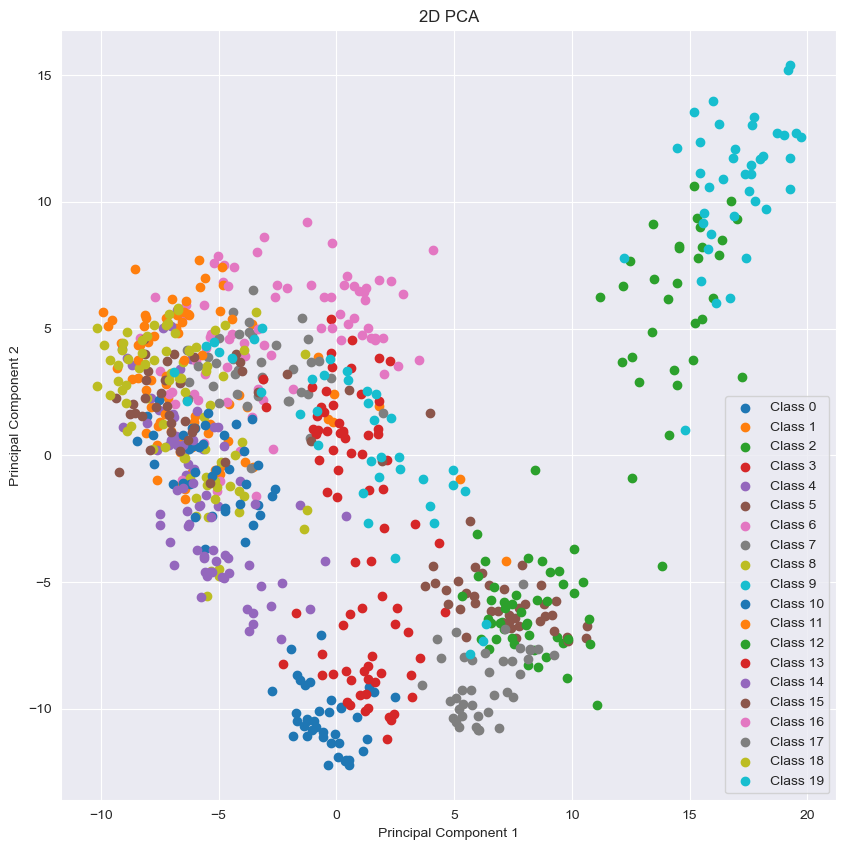

--------------------------------------------------------
Number of components: 3


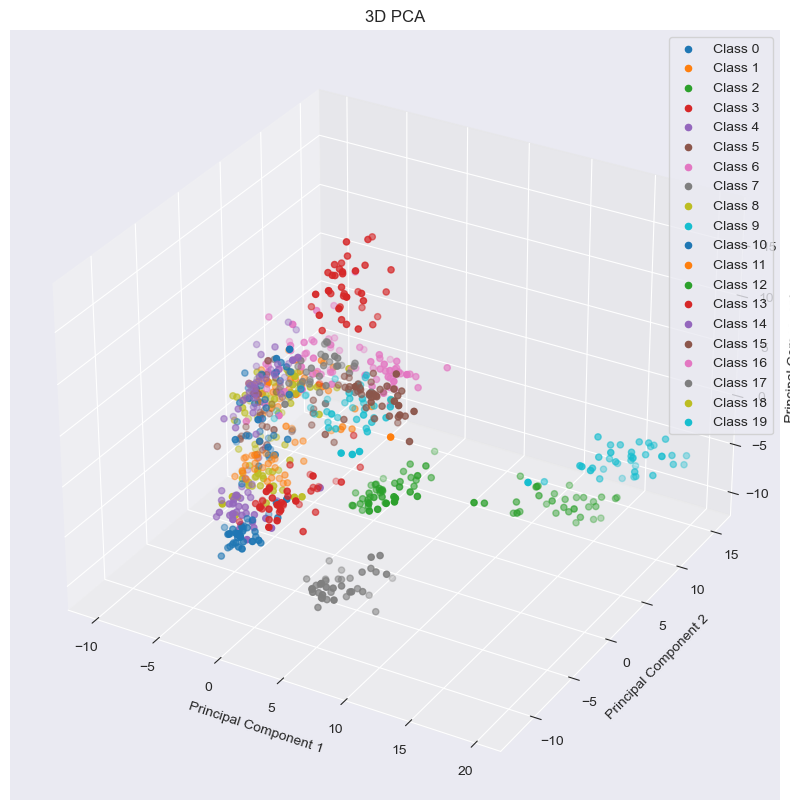

In [10]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA  # Corrected import statement

# Assuming your data loading code remains the same...

# Load your datasets
X_train = np.load('train_features.npy')
X_val = np.load('val_features.npy')
X_test = np.load('test_features.npy')
y_train = np.load('train_labels.npy')
y_val = np.load('val_labels.npy')
y_test = np.load('test_labels.npy')

num_components = [2, 3]
for num_component in num_components: 
    print("--------------------------------------------------------")
    print(f"Number of components: {num_component}")
    new_pca = PCA(n_components=num_component)  # Corrected to use PCA from sklearn
    projected_data = new_pca.fit_transform(X_train)

    X_train_new = np.real(projected_data)
    X_val_new = np.real(new_pca.transform(X_val))
    X_test_new = np.real(new_pca.transform(X_test))

    X_new = np.concatenate((X_train_new, X_val_new, X_test_new))
    y_new = np.concatenate((y_train, y_val, y_test))

    classes = np.unique(y_new)
    if num_component == 2:
        plt.figure(figsize=(10,10))
        ax = plt.axes()
        for i in range(len(classes)):
            ax.scatter(X_new[y_new == i, 0], X_new[y_new == i, 1], label=f'Class {classes[i]}')
        ax.legend()
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title('2D PCA')
        plt.show()
    elif num_component == 3:
        plt.figure(figsize=(10,10))
        ax = plt.axes(projection='3d')
        for i in range(len(classes)):
            ax.scatter(X_new[y_new == i, 0], X_new[y_new == i, 1], X_new[y_new == i, 2], label=f'Class {classes[i]}')
        ax.legend()
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        plt.title('3D PCA')
        plt.show()